In [60]:
using RxInfer, Random, LinearAlgebra, Plots, Flux, Plots, StableRNGs, SpecialFunctions, Rocket
using CCMP

In [61]:
@rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple{1}, M <: CVI} = begin
    method = ReactiveMP.getmethod(meta)
    node = getnode()
    m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
    m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))
    q_y_params = naturalparams(prod(method, getdata(m_ins[1]), getdata(m_out), q_ins[1], getnodefn(Val(:out))))
    return convert(Distribution, q_y_params - naturalparams(getdata(m_out)))
end

In [111]:
# data generating process
nr_observations = 50
reference_point = 53
hidden_location = collect(1:nr_observations) + rand(MersenneTwister(124), NormalMeanVariance(0.0, sqrt(100)), nr_observations)
measurements = (hidden_location .- reference_point).^2 + rand(MersenneTwister(124), NormalMeanVariance(0.0, 200), nr_observations);

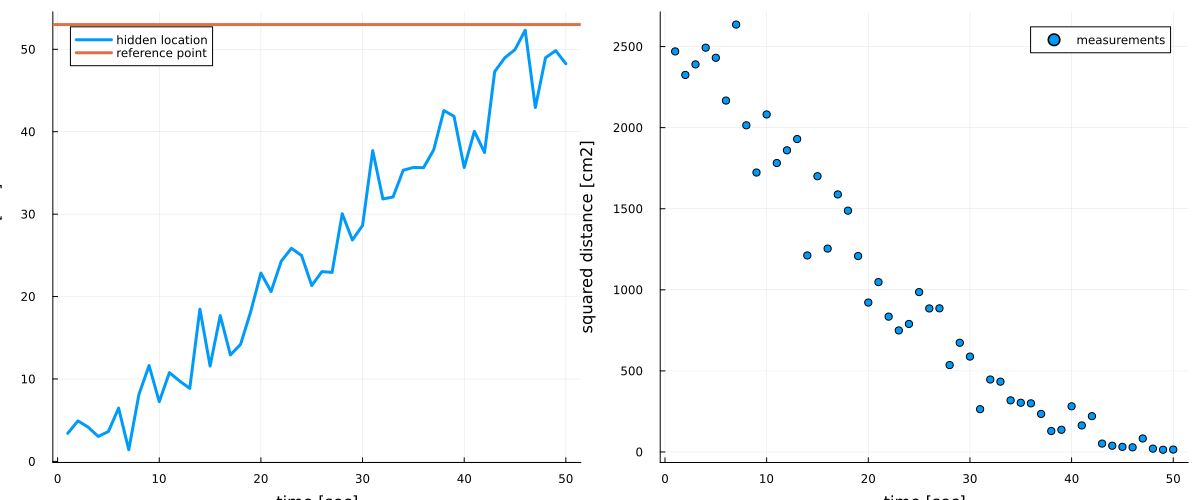

In [112]:
# plot hidden location and reference frame
p1 = plot(1:nr_observations, hidden_location, linewidth=3, legend=:topleft, label="hidden location")
hline!([reference_point], linewidth=3, label="reference point")
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot measurements
p2 = scatter(1:nr_observations, measurements, linewidth=3, label="measurements")
xlabel!("time [sec]"), ylabel!("squared distance [cm2]")

plot(p1, p2, size=(1200, 500))

In [113]:
function compute_squared_distance(z)
    (z - reference_point)^2
end;

In [114]:
@model function measurement_model(nr_observations)

    # allocate random variables and observations
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)

    # set priors on precision parameters
    τ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    γ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    
    # specify estimate of initial location
    z[1] ~ Normal(mean = 0, precision = τ)
    y[1] ~ Normal(mean = compute_squared_distance(z[1]), precision = γ)

    # loop over observations
    for t in 2:nr_observations

        # specify state transition model
        z[t] ~ Normal(mean = z[t-1] + 1, precision = τ)

        # specify non-linear observation model
        y[t] ~ Normal(mean = compute_squared_distance(z[t]), precision = γ)
        
    end

end

In [115]:
@meta function measurement_meta(rng, nr_samples, nr_iterations, optimizer)
    compute_squared_distance() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 10, Val(true), false)
end;

In [116]:
@constraints function measurement_constraints()
    q(z, τ, γ) = q(z)q(τ)q(γ)
end;

In [123]:
results = inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 5,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 100, 200, Descent(0.01)),
    initmessages = (z = NormalMeanVariance(0, 100),),
    initmarginals = (z = NormalMeanVariance(0, 100), τ = GammaShapeRate(1, 1000), γ = GammaShapeRate(1, 1000),),
)

Inference results:
  Posteriors       | available for (z)
  Free Energy:     | Real[397.456, 388.004, 388.685, 388.208, 388.166]


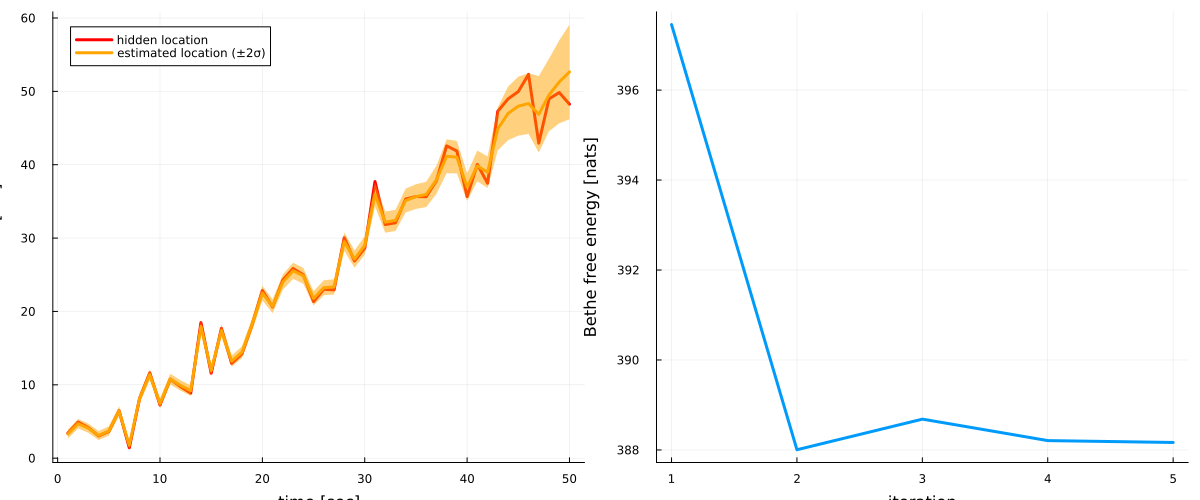

In [124]:
# plot estimates for location
p1 = plot(collect(1:nr_observations), hidden_location, label = "hidden location", legend=:topleft, linewidth=3, color = :red)
plot!(map(mean, results.posteriors[:z]), label = "estimated location (±2σ)", ribbon = map(x -> 2*std(x), results.posteriors[:z]), fillalpha=0.5, linewidth=3, color = :orange)
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot Bethe free energy
p2 = plot(results.free_energy, linewidth=3, label = "")
xlabel!("iteration"), ylabel!("Bethe free energy [nats]")

plot(p1, p2, size = (1200, 500))